# Современные методы машинного обучения. 
# Семинар 8. Автоэнкодеры

## 1. Подход 

Автоэнкодеры - unsupervised (не требующие разметки данных) модели, которые находят применение как важные строительные блоки в огромном кол-ве сложных моделей и подходов.

Идея автоэнкодера крайне проста - он состоит из двух нейронных сетей, называемых _энкодером_ и _декодером_, которые работают в тандеме. Задача энкодера - сжать исходный объект до вектора малой размерности, называемого _латентным кодом_ (или _скрытым представлением_). Задача декодера - восстановить из этого латентного кода исходный объект. 

![Архитектура автоэнкодера](https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png)

Источник картинки: [medium](https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f)


Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$ Loss = \sum MSE(x_i, dec(enc(x_i)) $$

## 2. Пишем простой автоэнкодер для MNIST

Давайте реализуем и поиграемся с простым автоэнкодером, который берет изображения из датасета **MNIST** и кодирует их в латентные коды длины **k**. В этом задании надо реализовать:

* Encoder
    * Четырехслойная полносвязная сеть с каналами (784-128-64-32-k)
* Decoder
    * Симметричная полносвязная сеть с каналами (k-32-64-128-784) и сигмоида в конце
* Loss функцию для обучения
    * L2 между входом и выходом автоэнкодера

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

%matplotlib inline

from IPython.display import clear_output

device = "cuda:0"

In [2]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder, self).__init__()
        self.lat_size = lat_size
        
        
        self.enc_net = # YOUR CODE HERE
        
    def forward(self, x):
        assert x.shape[2] == x.shape[3] == 28
        
        z = self.enc_net(x)
        
        assert z.shape[0] == x.shape[0]
        assert z.shape[1] == self.lat_size
        
        return z
    
class MNISTDecoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = # YOUR CODE HERE
        
    def forward(self, z):
        assert z.shape[1] == self.lat_size
        
        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        assert x_rec.shape[0] == z.shape[0]
        
        return x_rec

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, lat_size, 
                 encoder_class=MNISTEncoder, 
                 decoder_class=MNISTDecoder,
                 criterion_class=# YOUR CODE HERE):
        super(AutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)

        self.criterion = criterion_class()
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def compute_loss(self, x, return_rec=False):
        z = self.encode(x)
        rec_x = self.decode(z)
        
        loss = self.criterion(x, rec_x)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

Теперь давайте обучим автоэнкодер

In [4]:
def train_model(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for iter_i, batch in enumerate(tr_dataloader):
            x, _ = batch
            x = x.to(device)

            optimizer.zero_grad()  # Зануляем градиенты

            loss, rec_x = model.compute_loss(x, return_rec=True)

            loss.backward()  # Считаем градиенты
            optimizer.step()  # Обновляем параметры модели

            loss_trace.append(loss.item())

            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("L2 loss (x, x_rec)")
                plt.plot(loss_trace)

                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis("off")
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap="gray")

                    plt.subplot(2, 6, 10 + i)
                    plt.axis("off")
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap="gray")

                plt.show()

    model.eval()

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=1
)

testset = torchvision.datasets.MNIST(
    root="./mnist", train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=1
)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


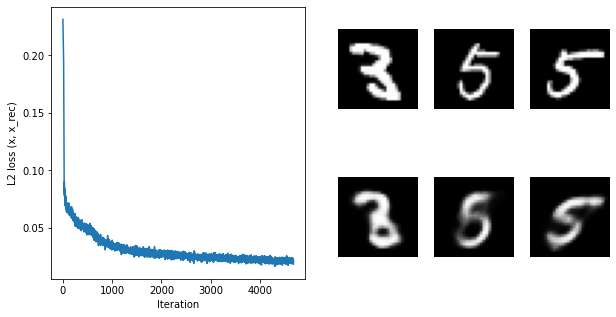

In [6]:
# обучим модель с латентным кодом длины 8

model = AutoEncoder(8)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_dataloader, optimizer)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

## 3. Структура и интерпретация латентного пространства.

Главная ценность автоэнкодера как модели - его латентный код. Он крайне информативный, т.к. он должен сохранять как можно больше важных деталей об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном. 

В этой части мы проиллюстрируем эти свойства.

### 3.1 Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответсвующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера. 

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [11]:
for x, _ in train_dataloader:
    break

x1 = x[0].to(device)
x2 = x[1].to(device)

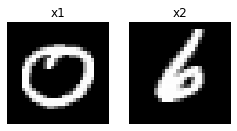

In [12]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("x1")
plt.imshow(x1[0].cpu().detach().numpy(), cmap="gray")

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("x2")
plt.imshow(x2[0].cpu().detach().numpy(), cmap="gray")

In [13]:
# получите латентные коды объектов
z_1 = # YOUR CODE HERE
z_2 = # YOUR CODE HERE
assert z_1.shape == z_2.shape == torch.Size([1, 8])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = # YOUR CODE HERE
z_linspace = # YOUR CODE HERE
assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = # YOUR CODE HERE
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

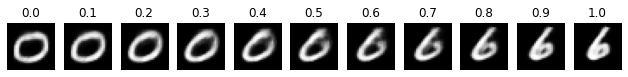

In [14]:
# нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis("off")
    plt.title(f"{d:.2}")
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap="gray")

На интерполяция видно, как один объект плавно превращается в другой. Стоит заметить, что почти все промежуточные объекты тоже выглядят довольно правдопободно. Иногда такие интерполяции используют для того, чтобы расширить какой-то маленький датасет.

### 3.2 Структура латентного пространства

Теперь давайте обучим автоэнкодер с **2** латентными кодами, соберем эти латентные коды и нарисуем 2d scatter plot, где латентные коды подсвечены цветами классов исходных объектов.

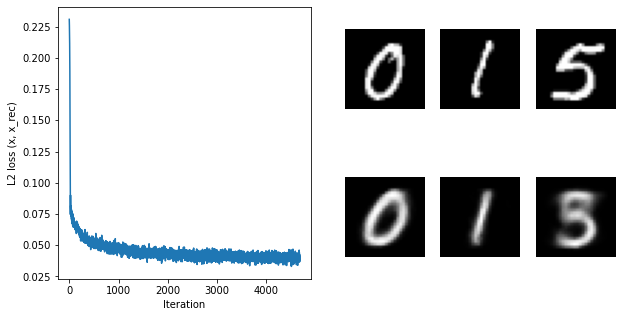

In [16]:
# обучим автоэнкодер с 2 латентными кодами

model_2d = AutoEncoder(2)
model_2d.to(device)
optimizer = optim.Adam(model_2d.parameters(), lr=1e-3)

train_model(model_2d, train_dataloader, optimizer)

In [17]:
def get_latent_codes_and_labels(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        # YOUR CODE HERE

        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels


# соберем для 1000 случайных объектов их латентные коды и классы
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_2d, 1000)

assert lat_codes.shape == (1000, 2)
assert labels.shape == (1000,)

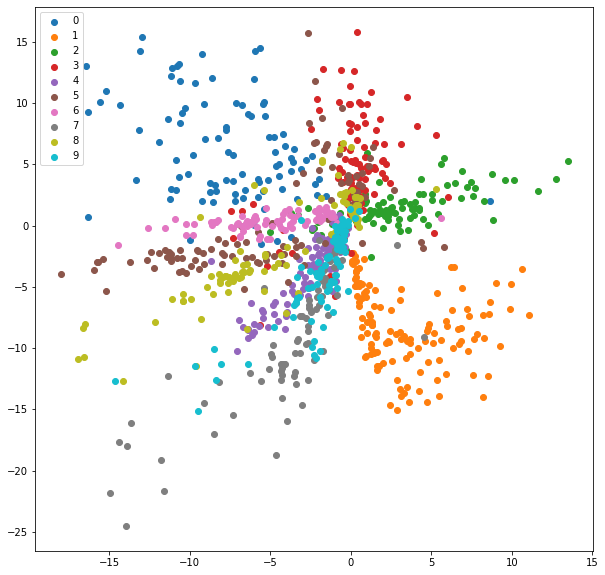

In [18]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f"{cl}")
plt.legend()
plt.show()

Объекты одного и то же класса находятся в латентном пространстве близко друг к другу! При этом визуально похожие классы (1-4 или 4-9) тоже находятся в соседних областях.

## 4. Применения

### 4.1 Semi-supervised learning.

Представим, что у нас следующая ситуация. Есть огромный датасет (тысячи объектов), но по тем или иным причинам размечена у него только малая часть (скажем, сотня) объектов. Например, причиной может быть дороговизна разметки или необходимость привлечения эксперта. Однако, мы хотим научиться решать эту задачу и должны как-то научиться использовать неразмеченные данные.

В такой ситуации можно обучить автоэнкодер на всем датасете (размеченные + неразмеченные объекты) и использовать его латентные коды от размеченных объектов для обучения другой модели (например, из классического ML), которая не требовательна к объему данных.

In [20]:
# предположим, у нас размечено только 1000 (из 50000) объектов из MNIST
# возьмем для них латентные коды

train_lat_codes, train_labels = get_latent_codes_and_labels(
    train_dataloader, model, 1000
)

assert train_lat_codes.shape == (1000, 8)
assert train_labels.shape == (1000,)

# так же обсчитаем весь тест сет
test_lat_codes, test_labels = get_latent_codes_and_labels(test_dataloader, model, 10000)

assert test_lat_codes.shape == (10000, 8)
assert test_labels.shape == (10000,)

In [22]:
# обучим на них случайный лес
from sklearn.ensemble import RandomForestClassifier

clfr = # YOUR CODE HERE
# YOUR CODE HERE

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
test_pred = clfr.predict(test_lat_codes)

In [24]:
print(f"Test accuracy: {(test_pred == test_labels).mean()}")

Test accuracy: 0.8643


Довольно хорошее качество для такого малого объема размеченных данных. Кроме того, мы смогли совместить преимущества нейросетевого и классичего подхода и взять от них самое лучшее (нетребовательность к данным от ML и способность работы со сложноструктурированными данными от DL).

Своего рода, это частный случай fine-tuning для ситуации, когда исходная сетка (энкодер) обучалась на неразмеченных данных.

### 4.2 Denoising.

Кроме того, автоэнкодеры часто используют для очистки исходных данных от шума. Латентный код сохраняет только главную информацию об объекте, отбрасывая шумовые компоненты. 

Давайте реализуем функцию, которая обращает c вероятностью 0.1 каждый пиксель исходного изображения, и обучим на такой выборке автоэнкодер.

In [27]:
class FlipRandomBits(object):
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio

    def __call__(self, x):
        # YOUR CODE HERE

        return x


transform = transforms.Compose([transforms.ToTensor(), FlipRandomBits()])

trainset_with_noise = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
train_dataloader_with_noise = torch.utils.data.DataLoader(
    trainset_with_noise, batch_size=64, shuffle=True, num_workers=0
)

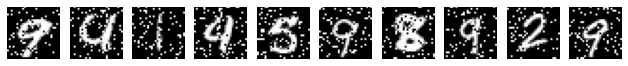

In [28]:
for x, y in train_dataloader_with_noise:
    break

plt.figure(figsize=(11, 1))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap="gray")

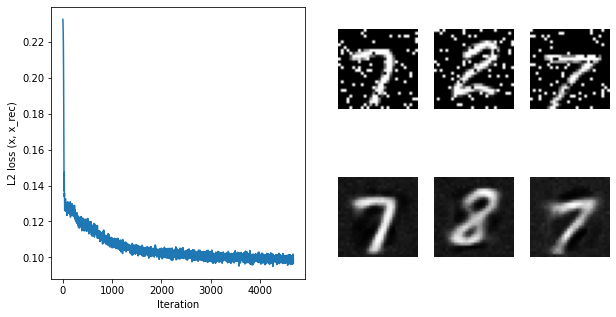

In [30]:
# обучим автоэнкодер на зашумленных данных

model_for_noise = AutoEncoder(8)
model_for_noise.to(device)
optimizer = optim.Adam(model_for_noise.parameters(), lr=1e-3)

train_model(model_for_noise, train_dataloader_with_noise, optimizer)

Восстановленные объекты не содержат шума, которым мы испортили данные! 

Этот эксперимент должен Вам напомнить метод главных компонент (PCA) из классического ML, который тоже часто используют для сжатия данных и избавления от шума. PCA является частным случаем автоэнкодера с линейными энкодером и декодером.